In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display
import random
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.exceptions import FitFailedWarning
import xgboost as xgb
warnings.filterwarnings('ignore', category=FitFailedWarning)
from google.colab import drive

sns.set(font_scale=0.6)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/2016_LA_merged_scaled.csv", delimiter=",")
df.head()

In [ ]:
# limit to only input fetaures to be used
X = df[['RED', 'GREEN', 'BLUE', 'SWIR1',
       'NDVI', 'NDBI', 'NBAI', 'MNDWI', 'EVI', 'LST', 'Elevation', 'Slope', 'sin_time', 'cos_time',
       'Water_dist']]
y = df['temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### simple point-wise regression

In [ ]:
def compute_metrics_and_plot(name, y_test, y_pred, params, output_df):
  '''
  runs evaluation metrics given predictions and true data, plots them, and appends values to array
  '''
  # run evaluation metrics
  mae = mean_absolute_error(y_test, y_pred)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)

  print(f'{name} MAE: {mae:.4f}')
  print(f'{name} MSE: {mse:.4f}')
  print(f'{name} RMSE: {rmse:.4f}')
  print(f'{name} R2: {r2:.4f}')

  # plot simple predicted vs real plot
  plt.figure(figsize=(8, 6))
  plt.scatter(y_test, y_pred, alpha=0.5)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Actual vs. Predicted Values")
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='red', lw=2)
  plt.show()

  # save values in df
  output_df.loc[len(output_df)] = [
        {name},
        params,
        mae,
        mse,
        rmse,
        r2
  ]

  return output_df

In [ ]:
def find_params_and_fit_model(name, model, params, output_df):
  '''
  performs RandomSearch for hyperparameter tuning and fits model with best parameters
  '''
  print(f"Computing {name} model:")

  # no params to sample for linear regression
  if name == 'linear':
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

  # else perform RandomSearch to sample random params and find the best ones
  else:
      random_search = RandomizedSearchCV(
          model,
          param_distributions=params,
          n_iter=100,
          scoring='neg_mean_squared_error',
          cv=5, verbose=1, random_state=42, n_jobs=-1
      )

      random_search.fit(X_train, y_train)

      print("Best parameters from RandomizedSearchCV: ", random_search.best_params_)
      best_model = random_search.best_estimator_
      y_pred = best_model.predict(X_test)


  output_df = compute_metrics_and_plot(name, y_test, y_pred, random_search.best_params_ if name != 'linear' else '-', output_df)
  return output_df, model if name == 'linear' else best_model

In [ ]:
# Define output_df to save values in
output_df = pd.DataFrame(columns=['Model', 'Best Parameters', 'MAE', 'MSE', 'RMSE', 'R2'])

Computing linear model:
linear MAE: 2.4654
linear MSE: 9.7207
linear RMSE: 3.1178
linear R2: 0.7211


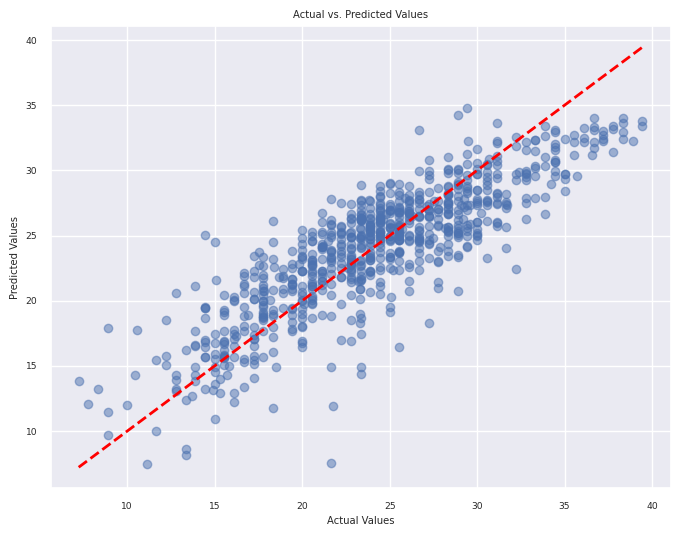

In [ ]:
output_df, model_linear = find_params_and_fit_model('linear', LinearRegression(), None, output_df)

Computing Decision Tree model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [ -7.33380269          nan  -7.74145295  -9.9361445  -20.13580346
          nan          nan          nan -20.13580346 -12.5247405
 -11.18706943  -8.15931688  -8.60679915 -18.77664236  -8.71211342
  -9.59646167 -19.79973065  -8.59975051  -6.91521302 -15.76164719
          nan          nan -15.0034257           nan          nan
 -20.13580346 -15.03929385 -11.18706943  -8.71211342          nan
 -12.2023062   -8.02916446 -10.01372537          nan -15.80017586
 -10.24535888 -13.18562066  -9.90874279 -15.64004524 -16.39976791
 -10.28982479  -7.90696155          nan          nan          nan
  -6.91545888 -20.13580346          nan -12.02697386 -10.01372537
  -8.71211342 -18.77664236  -9.44653591  -7.55540843  -8.71211342
 -11.18706943  -8.61118536  -8.75327878  -8.85678433  -7.60639552
  -9.4519397  -10.6008627  -20.13580346          nan  -7.57579055
 -

Best parameters from RandomizedSearchCV:  {'splitter': 'best', 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': 24, 'criterion': 'friedman_mse'}
Decision Tree MAE: 1.9958
Decision Tree MSE: 7.3310
Decision Tree RMSE: 2.7076
Decision Tree R2: 0.7896


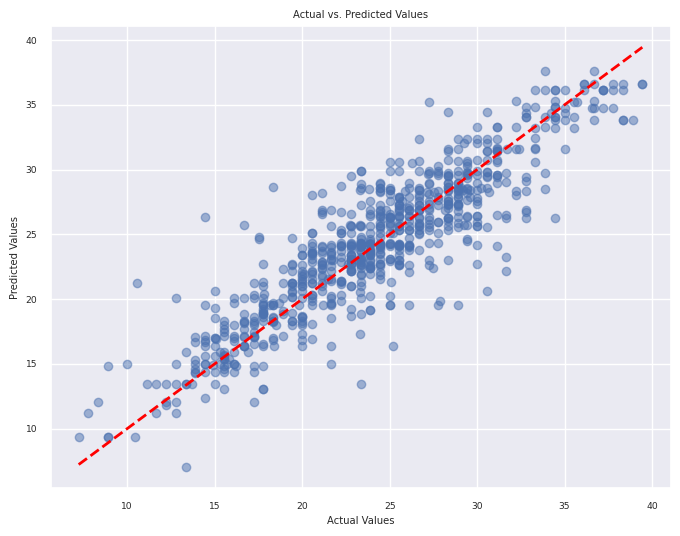

In [ ]:
output_df, model_dt = find_params_and_fit_model(
    'Decision Tree',
    DecisionTreeRegressor(random_state=42),
    {
        'criterion': ["squared_error", "friedman_mse"],
        'splitter': ['best', 'random'],
        'max_depth': [2, 4, 8, 24, 48, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 4, 8],
        'max_features': ['auto', 'sqrt', 'log2', None],

    },
    output_df)

Computing XGBoost model:
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters from RandomizedSearchCV:  {'subsample': 0.75, 'min_child_weight': 2, 'max_depth': 6, 'gamma': 0, 'eta': 0.1}
XGBoost MAE: 1.3991
XGBoost MSE: 3.4926
XGBoost RMSE: 1.8689
XGBoost R2: 0.8998


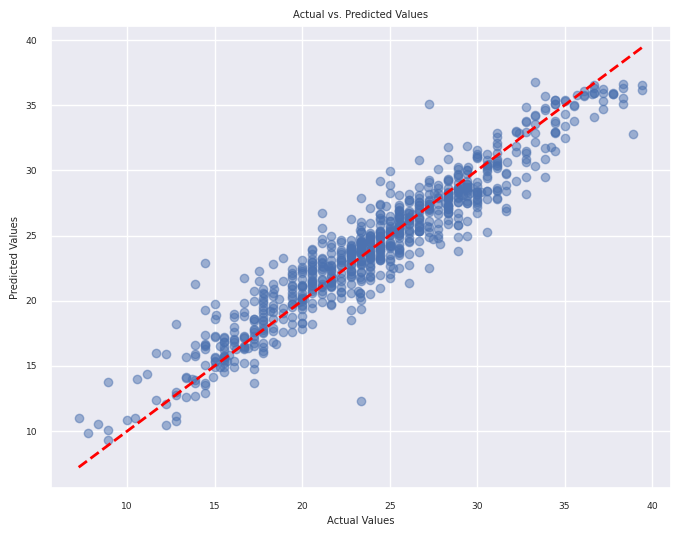

In [ ]:
output_df, model_xgb = find_params_and_fit_model(
    'XGBoost',
    xgb.XGBRegressor(random_state=42),
    {
      'eta': [0.075, 0.1, 0.3],
      'gamma': [0, 2, 4, 8, 16],
      'max_depth': [4, 6, 48, 128],
      'min_child_weight': [0, 1, 2],
      'subsample': [0.2, 0.75, 0.8, 1],
    },
    output_df)

# used when rerunning, given randomsearch takes a long time
# model_xgb = xgb.XGBRegressor(subsample= 0.75, min_child_weight= 2, max_depth=6, gamma= 0, eta= 0.1, random_state=42)
# model_xgb.fit(X_train, y_train)
# y_pred = model_xgb.predict(X_test)
# output_df = compute_metrics_and_plot('XGBoost', y_test, y_pred,"{'subsample': 0.75, 'min_child_weight': 2, 'max_depth': 6, 'gamma': 0, 'eta': 0.1}", output_df)

RandomForest MAE: 1.5910
RandomForest MSE: 4.5315
RandomForest RMSE: 2.1287
RandomForest R2: 0.8700


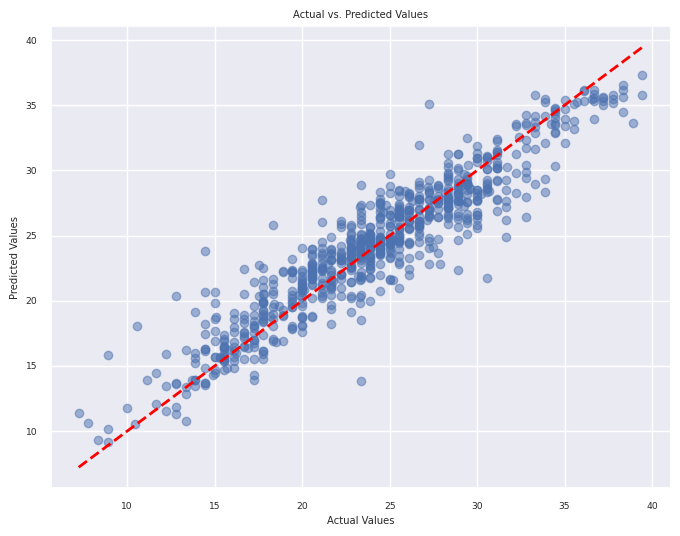

In [ ]:
# RF ran for 35+ min for random search, instead limited n_iter;cv;n_estimators

model_rf = RandomForestRegressor(n_estimators=512, max_features=None, max_depth=128, criterion='friedman_mse', random_state=42)
model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

output_df = compute_metrics_and_plot('RandomForest', y_test, y_pred,"{'n_estimators': 512, 'max_features': None, 'max_depth': 128, 'criterion': 'friedman_mse'}", output_df)

In [ ]:
output_df.sort_values(by='R2', ascending=False)

,Model,Best Parameters,MAE,MSE,RMSE,R2
4,{XGBoost},"{'subsample': 0.75, 'min_child_weight': 2, 'ma...",1.399071,3.492617,1.868855,0.899783
3,{RandomForest},"{'n_estimators': 512, 'max_features': None, 'm...",1.590980,4.531539,2.128741,0.869972
1,{Decision Tree},"{'splitter': 'best', 'min_samples_split': 5, '...",1.995786,7.330952,2.707573,0.789645
0,{linear},-,2.465450,9.720681,3.117801,0.721075


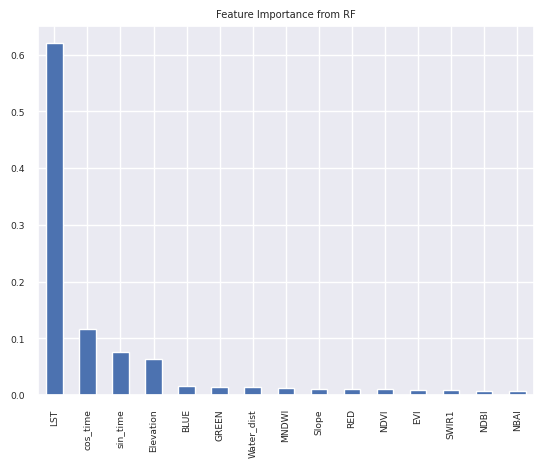

In [ ]:
forest_importances = pd.Series(model_rf.feature_importances_, index=X.columns)
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_], axis=0)

forest_importances.sort_values(ascending=False)[:40].plot(kind='bar')
plt.title('Feature Importance from RF')
plt.xticks(rotation=90)
plt.show()

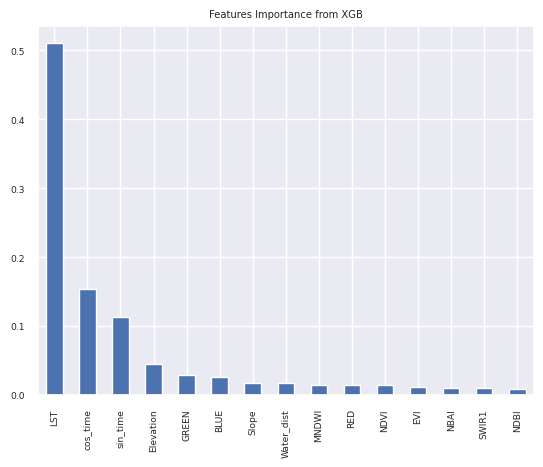

In [ ]:
xgb_importances = pd.Series(model_xgb.feature_importances_, index=X.columns)

xgb_importances.sort_values(ascending=False)[:40].plot(kind='bar')
plt.title('Features Importance from XGB')
plt.xticks(rotation=90)
plt.show()